# Step 0: Import python libraries

In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil

from astropy.io import fits


# Step 1: Search for and store BepiColombo data products using the search API

In [2]:
response = requests.get('https://pds.nasa.gov/api/search/1/products?q=((pds:Science_Facets.pds:wavelength_range eq "Visible") '
                        'and (pds:Investigation_Area.pds:name eq "BepiColombo") '
                        'and (pds:Header.pds:parsing_standard_id eq "FITS 3.0")'
                        'and (pds:Time_Coordinates.pds:start_date_time gt "2022-04-30T00:00:00Z")'
                        '  )&start=0&limit=3000')

resp_data = response.json()['data']

### Store image URLS in a list format to load for visualization

In [3]:
urls = [prod['properties']['ops:Data_File_Info.ops:file_ref'][0] for prod in resp_data]
urls[0]

'https://archives.esac.esa.int/psa/repo/esa/psa/bc_mtm_mcam/data_raw/2022-05-02/cam_raw_sc_cam1_image_20220501t001026_56_f__t0004/1.0/cam_raw_sc_cam1_image_20220501t001026_56_f__t0004.fits'

# Step 2: Grid Visualization of Image Data
Specify the page you would like to see with the page parameter below. Each page displays 48 image products. The current time query is viewing BC's mercury flyby on the 23rd of June 2022.

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

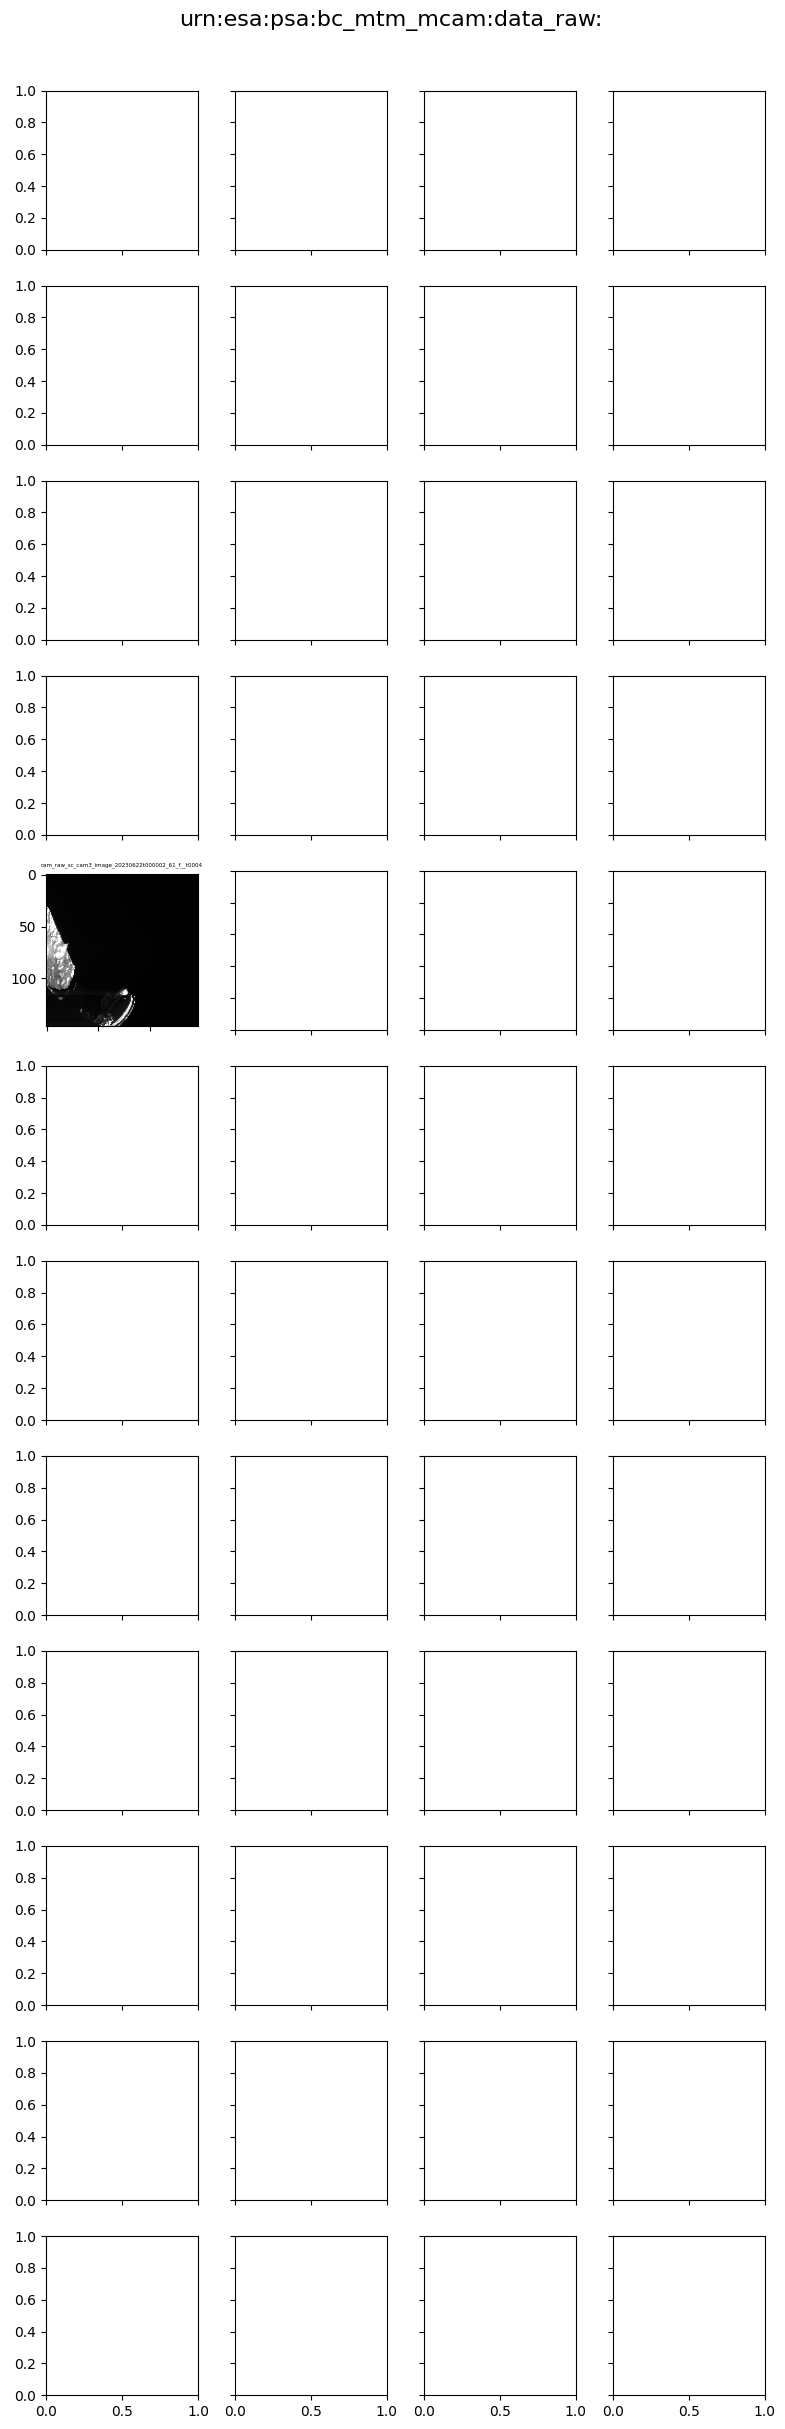

In [4]:
#EDIT THIS VARIABLE TO CHANGE PAGES
PAGE = 1
#EDIT THIS VARIABLE TO CHANGE SUBSAMPLING
SUBSAMPLING_RATE = 7 #Indicates how many pixels to skip when plotting

fig, axs = plt.subplots(12,4 , figsize=(8, 24))
NUM_COLUMNS = 4
NUM_ROWS = 12
size = NUM_COLUMNS*NUM_ROWS

for i, image_path in enumerate(urls[size*(PAGE-1):size*PAGE]):
    response = requests.get(image_path)
    with fits.open(image_path) as hdul:
        image_data = hdul[1].data
    row_col = divmod(16,4)
    axs[row_col[0], row_col[1]].imshow(image_data[0::SUBSAMPLING_RATE,0::SUBSAMPLING_RATE], cmap='gray')
    #Split the lid by ':' and select the last part of the lid for each image title
    axs[row_col[0], row_col[1]].set_title(resp_data[i]['properties']['lid'][0].split(':')[5], fontsize = 4)
    #Free up memory
    del image_data

for ax in axs.flat:
    ax.label_outer()

plt.suptitle('urn:esa:psa:bc_mtm_mcam:data_raw:', fontsize=16,y=1.01)

plt.tight_layout()
plt.show()
